## Model tuning of Z2 seasonal cycle
##### Looking at seasonal cycles (both depth-averaged and depth-integrated) observation zooplankton specific to the Z2 class
##### Comparing to current model seasonal cycle presented in Figure 3 of Olson et al. (2020)

##### Note: Current Z2 seasonal cycle is based on Strait of Georgia data only

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
from salishsea_tools import evaltools as et, viz_tools
import os
import datetime as dt
import gsw
import matplotlib.gridspec as gridspec
import matplotlib as mpl
import matplotlib.dates as mdates
import cmocean as cmo
import scipy.interpolate as sinterp
import cmocean
import json
import f90nml
from collections import OrderedDict

fs=16
mpl.rc('xtick', labelsize=fs)
mpl.rc('ytick', labelsize=fs)
mpl.rc('legend', fontsize=fs)
mpl.rc('axes', titlesize=fs)
mpl.rc('axes', labelsize=fs)
mpl.rc('figure', titlesize=fs)
mpl.rc('font', size=fs)
mpl.rc('font', family='sans-serif', weight='normal', style='normal')

import warnings
#warnings.filterwarnings('ignore')
from IPython.display import Markdown, display

%matplotlib inline


### Import Puget Sound Data (2014-2019 only)

In [2]:
PSdf=pd.read_excel('/ocean/ksuchy/MOAD/analysis-karyn/notebooks/PugetSoundZoopBiomass/PugetSoundMesoZoopBiomassDF_Publication.xlsx',engine='openpyxl')

In [3]:
PSdf

,Unnamed: 0,Key,Station,Site Name,Basin,Sub Basin,Lat,Lon,Sample Date,Sample Year,...,GLEBOCARCINUS OREGONENSIS,LOPHOPANOPEUS BELLUS,METACARCINUS GRACILIS,METACARCINUS MAGISTER,PINNIXA,PINNOTHERES,PUGETTIA,Year,YD,Total
0,0,010218ELIV1151,ELIV,Eliza Island,Bellingham Bay,Bellingham Bay,48.63795,-122.5694,2018-01-02,2018,...,0.0,0.0,0.00000,0.485673,0.0,0.0,0.000000,2018,2,7.707972
1,1,010818SKETV1058,SKETV,South Ketron/Solo Point,South Sound,South Sound,47.15243,-122.6586,2018-01-08,2018,...,0.0,0.0,0.87668,0.438340,0.0,0.0,0.000000,2018,8,10.461341
2,2,011119ELIV1052,ELIV,Eliza Island,Bellingham Bay,Bellingham Bay,48.63795,-122.5694,2019-01-11,2019,...,0.0,0.0,0.00000,0.000000,0.0,0.0,0.000000,2019,11,5.705943
3,3,011315CAMV1330,CAMV,Camano Head,Whidbey Basin,S Whidbey Basin,48.05901,-122.3873,2015-01-13,2015,...,0.0,0.0,0.00000,0.572797,0.0,0.0,0.000000,2015,13,14.000355
4,4,011315MUKV1415,MUKV,Mukilteo,Whidbey Basin,S Whidbey Basin,47.97166,-122.3222,2015-01-13,2015,...,0.0,0.0,0.00000,1.098103,0.0,0.0,0.000000,2015,13,27.594135
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1154,1154,121917LSNT01V1000,LSNT01V,Point Williams,Central Basin,N Central Basin,47.53333,-122.4333,2017-12-19,2017,...,0.0,0.0,0.00000,0.000000,0.0,0.0,0.000000,2017,353,16.281018
1155,1155,121917NSEX01V1224,NSEX01V,East Passage,Central Basin,S Central Basin,47.35862,-122.3871,2017-12-19,2017,...,0.0,0.0,0.00000,0.000000,0.0,0.0,0.000000,2017,353,26.271637
1156,1156,121918TDBV1327,TDBV,Thorndyke Bay,Hood Canal,N Hood Canal,47.78297,-122.7330,2018-12-19,2018,...,0.0,0.0,0.17734,0.000000,0.0,0.0,0.000000,2018,353,9.384936
1157,1157,122116LSNT01V1057,LSNT01V,Point Williams,Central Basin,N Central Basin,47.53333,-122.4333,2016-12-21,2016,...,0.0,0.0,0.00000,0.000000,0.0,0.0,0.000000,2016,356,13.617276


### Import data from Canadian waters of the Salish Sea (1996-2019)*
##### *includes almost 10 more years than Olson et al. 2020

In [4]:
SoGdf=pd.read_excel('/ocean/ksuchy/MOAD/analysis-karyn/notebooks/Evaluations/SoGMesoZoopBiomassDF_1996-2019.xlsx',engine='openpyxl')

In [5]:
SoGdf

,Unnamed: 0,Key,region_name,Station,lon,lat,Date,dtUTC,Twilight,Net_Type,...,Calanoida,Aphragmophora,Leptothecate,Trachylina,Anthoathecatae,Phragmophora,Year,Month,YD,Total
0,0,HAK2016096000401,Northern Strait of Georgia,QU39,-125.099,50.031,10/24/2016,2016-10-24 17:19:00,Daylight,Bongo VNH,...,0.00000,0.73362,0.00000,0.91531,0.00000,0.00000,2016,10,298,18.899221
1,1,HAK2016096000501,Northern Strait of Georgia,QU39,-125.099,50.031,11/10/2016,2016-11-10 17:50:00,Daylight,Bongo VNH,...,0.00000,0.10113,0.35548,1.07887,0.00000,0.00000,2016,11,315,10.445562
2,2,HAK2016096000901,Northern Strait of Georgia,QU39,-125.099,50.031,12/5/2016,2016-12-05 21:29:00,Daylight,Bongo VNH,...,0.00000,0.30036,0.09764,3.50036,0.00000,0.00000,2016,12,340,4.178025
3,3,HAK2016096001001,Northern Strait of Georgia,QU39,-125.099,50.031,12/14/2016,2016-12-14 18:00:00,Daylight,Bongo VNH,...,0.00000,0.02667,0.04687,0.91914,0.00000,0.00000,2016,12,349,2.266695
4,4,HAK2017097000101,Northern Strait of Georgia,QU39,-125.099,50.031,1/5/2017,2017-01-05 19:30:00,Daylight,Bongo VNH,...,0.00000,0.14426,0.04690,0.23449,0.00000,0.00000,2017,1,5,2.682855
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2406,2406,UVI2005000001401,Central Strait of Georgia,GEO1,-123.748,49.250,5/13/2005,2005-05-13 19:00:00,Daylight,SCOR VNH,...,3.33156,2.83936,7.66203,5.52293,0.00000,0.00000,2005,5,133,15.642981
2407,2407,UVI2005000001501,Central Strait of Georgia,GEO1,-123.748,49.250,5/13/2005,2005-05-13 19:15:00,Daylight,SCOR VNH,...,4.73331,0.15051,0.17165,4.75934,0.00000,0.12648,2005,5,133,8.563396
2408,2408,UVI2005000001601,Central Strait of Georgia,GEO1,-123.748,49.250,6/23/2005,2005-06-23 19:00:00,Daylight,SCOR VNH,...,0.00000,6.64691,0.55845,12.56888,0.00000,0.00000,2005,6,174,10.977998
2409,2409,UVI2005000001701,Central Strait of Georgia,GEO1,-123.748,49.250,6/23/2005,2005-06-23 19:15:00,Daylight,SCOR VNH,...,0.00000,1.17809,0.00994,2.02823,0.14455,0.00000,2005,6,174,6.282387


In [6]:
SoGdf.keys()

Index(['Unnamed: 0', 'Key', 'region_name', 'Station', 'lon', 'lat', 'Date',
       'dtUTC', 'Twilight', 'Net_Type', 'Mesh_Size(um)', 'DEPTH_STRT1',
       'DEPTH_END1', 'Bottom Depth(m)', 'Amphipoda', 'Thecostraca', 'Decapoda',
       'Euphausiacea', 'Calanoida', 'Aphragmophora', 'Leptothecate',
       'Trachylina', 'Anthoathecatae', 'Phragmophora', 'Year', 'Month', 'YD',
       'Total'],
      dtype='object')

In [7]:
SoGdf.rename(columns={'Aphragmophora':'Chaetognaths'},inplace=True)

In [8]:
SoGdf.keys()

Index(['Unnamed: 0', 'Key', 'region_name', 'Station', 'lon', 'lat', 'Date',
       'dtUTC', 'Twilight', 'Net_Type', 'Mesh_Size(um)', 'DEPTH_STRT1',
       'DEPTH_END1', 'Bottom Depth(m)', 'Amphipoda', 'Thecostraca', 'Decapoda',
       'Euphausiacea', 'Calanoida', 'Chaetognaths', 'Leptothecate',
       'Trachylina', 'Anthoathecatae', 'Phragmophora', 'Year', 'Month', 'YD',
       'Total'],
      dtype='object')

In [9]:
SoGdf.drop(labels=['Station','Twilight', 'Net_Type', 'Mesh_Size(um)','Bottom Depth(m)', 'Amphipoda', 'Euphausiacea', 'Calanoida',
       'Leptothecate','Chaetognaths', 'Trachylina','Thecostraca','Decapoda', 'Anthoathecatae',
       'Phragmophora', 'Year',
       'Month', ],axis=1,inplace=True) #removed 'YD' from drop list

In [10]:
SoGdf.keys()

Index(['Unnamed: 0', 'Key', 'region_name', 'lon', 'lat', 'Date', 'dtUTC',
       'DEPTH_STRT1', 'DEPTH_END1', 'YD', 'Total'],
      dtype='object')

In [11]:
#rename columns


In [12]:
PSdf.keys()

Index(['Unnamed: 0', 'Key', 'Station', 'Site Name', 'Basin', 'Sub Basin',
       'Lat', 'Lon', 'Sample Date', 'Sample Year', 'Sample Month',
       'Sample Time', 'Mesh Size', 'Diameter (cm)', 'Z', 'Z_lower', 'Z_upper',
       'dtUTC', 'CALANUS MARSHALLAE', 'CALANUS PACIFICUS', 'EUCALANUS',
       'EUCALANUS BUNGII', 'METRIDIA PACIFICA', 'NEOCALANUS PLUMCHRUS',
       'CYPHOCARIS CHALLENGERI', 'CALLIOPIUS PACIFICUS', 'GAMMARIDEA',
       'THEMISTO PACIFICA', 'EUPHAUSIA PACIFICA', 'THYSANOESSA RASCHII',
       'CHAETOGNATHA', 'CLYTIA GREGARIA', 'AEQUOREA VICTORIA',
       'AGLANTHA DIGITALE', 'BARNACLES', 'FABIA SUBQUADRATA',
       'CANCER PRODUCTUS', 'CANCRIDAE', 'Cancridae Lg', 'Cancridae Sm',
       'GLEBOCARCINUS OREGONENSIS', 'LOPHOPANOPEUS BELLUS',
       'METACARCINUS GRACILIS', 'METACARCINUS MAGISTER', 'PINNIXA',
       'PINNOTHERES', 'PUGETTIA', 'Year', 'YD', 'Total'],
      dtype='object')

In [13]:
#rename columns
#

In [14]:
PSdf.drop(labels=['Site Name','Station','Sub Basin', 'Sample Year', 'Sample Month',
       'Sample Time','Mesh Size', 'Diameter (cm)','Z',
        'CALANUS MARSHALLAE', 'CALANUS PACIFICUS', 'EUCALANUS',
       'EUCALANUS BUNGII', 'METRIDIA PACIFICA', 'NEOCALANUS PLUMCHRUS',
       'CYPHOCARIS CHALLENGERI', 'CALLIOPIUS PACIFICUS', 'GAMMARIDEA',
       'THEMISTO PACIFICA', 'EUPHAUSIA PACIFICA', 'THYSANOESSA RASCHII',
       'CHAETOGNATHA', 'CLYTIA GREGARIA', 'AEQUOREA VICTORIA',
       'AGLANTHA DIGITALE', 'BARNACLES', 'FABIA SUBQUADRATA',
       'CANCER PRODUCTUS', 'CANCRIDAE', 'Cancridae Lg', 'Cancridae Sm',
       'GLEBOCARCINUS OREGONENSIS', 'LOPHOPANOPEUS BELLUS',
       'METACARCINUS GRACILIS', 'METACARCINUS MAGISTER', 'PINNIXA',
       'PINNOTHERES', 'PUGETTIA', 'Year', ],axis=1,inplace=True) #removed 'YD' from drop list

In [15]:
PSdf.keys()

Index(['Unnamed: 0', 'Key', 'Basin', 'Lat', 'Lon', 'Sample Date', 'Z_lower',
       'Z_upper', 'dtUTC', 'YD', 'Total'],
      dtype='object')

In [16]:
PSdf.rename(columns={'Basin':'region_name','Sample Date':'Date'},inplace=True)

In [17]:
SoGdf.rename(columns={'lon':'Lon','lat':'Lat'},inplace=True)

In [18]:
SoGdf.rename(columns={'DEPTH_STRT1':'Z_lower','DEPTH_END1':'Z_upper'},inplace=True)

In [19]:
SoGdf.keys()

Index(['Unnamed: 0', 'Key', 'region_name', 'Lon', 'Lat', 'Date', 'dtUTC',
       'Z_lower', 'Z_upper', 'YD', 'Total'],
      dtype='object')

In [20]:
PSdf.keys()

Index(['Unnamed: 0', 'Key', 'region_name', 'Lat', 'Lon', 'Date', 'Z_lower',
       'Z_upper', 'dtUTC', 'YD', 'Total'],
      dtype='object')

In [21]:
PSdf['region_name'].unique()

array(['Bellingham Bay', 'South Sound', 'Whidbey Basin', 'Central Basin',
       'Hood Canal', 'Admiralty Inlet', 'San Juan'], dtype=object)

In [22]:
SalishSeadf=pd.concat([PSdf, SoGdf], ignore_index=True)

In [23]:
SalishSeadf

,Unnamed: 0,Key,region_name,Lat,Lon,Date,Z_lower,Z_upper,dtUTC,YD,Total
0,0,010218ELIV1151,Bellingham Bay,48.63795,-122.5694,2018-01-02 00:00:00,110.0,0,2018-01-02 19:51:00,2,7.707972
1,1,010818SKETV1058,South Sound,47.15243,-122.6586,2018-01-08 00:00:00,122.0,0,2018-01-08 18:58:00,8,10.461341
2,2,011119ELIV1052,Bellingham Bay,48.63795,-122.5694,2019-01-11 00:00:00,114.0,0,2019-01-11 18:52:00,11,5.705943
3,3,011315CAMV1330,Whidbey Basin,48.05901,-122.3873,2015-01-13 00:00:00,170.0,0,2015-01-13 21:30:00,13,14.000355
4,4,011315MUKV1415,Whidbey Basin,47.97166,-122.3222,2015-01-13 00:00:00,190.0,0,2015-01-13 22:15:00,13,27.594135
...,...,...,...,...,...,...,...,...,...,...,...
3565,2406,UVI2005000001401,Central Strait of Georgia,49.25000,-123.7480,5/13/2005,100.0,0,2005-05-13 19:00:00,133,15.642981
3566,2407,UVI2005000001501,Central Strait of Georgia,49.25000,-123.7480,5/13/2005,390.0,0,2005-05-13 19:15:00,133,8.563396
3567,2408,UVI2005000001601,Central Strait of Georgia,49.25000,-123.7480,6/23/2005,100.0,0,2005-06-23 19:00:00,174,10.977998
3568,2409,UVI2005000001701,Central Strait of Georgia,49.25000,-123.7480,6/23/2005,390.0,0,2005-06-23 19:15:00,174,6.282387


In [24]:
#create new columns
SalishSeadf['Month']=[ii.month for ii in SalishSeadf['dtUTC']]
SalishSeadf['Year']=[ii.year for ii in SalishSeadf['dtUTC']]

In [25]:
SalishSeadf['Total mg m2']=(SalishSeadf['Total'])*SalishSeadf['Z_lower']

In [26]:
SalishSeadf['Total mg m2'].mean()/1000

5.0184834304232036

In [27]:
SalishSeadf

,Unnamed: 0,Key,region_name,Lat,Lon,Date,Z_lower,Z_upper,dtUTC,YD,Total,Month,Year,Total mg m2
0,0,010218ELIV1151,Bellingham Bay,48.63795,-122.5694,2018-01-02 00:00:00,110.0,0,2018-01-02 19:51:00,2,7.707972,1,2018,847.876968
1,1,010818SKETV1058,South Sound,47.15243,-122.6586,2018-01-08 00:00:00,122.0,0,2018-01-08 18:58:00,8,10.461341,1,2018,1276.283548
2,2,011119ELIV1052,Bellingham Bay,48.63795,-122.5694,2019-01-11 00:00:00,114.0,0,2019-01-11 18:52:00,11,5.705943,1,2019,650.477556
3,3,011315CAMV1330,Whidbey Basin,48.05901,-122.3873,2015-01-13 00:00:00,170.0,0,2015-01-13 21:30:00,13,14.000355,1,2015,2380.060423
4,4,011315MUKV1415,Whidbey Basin,47.97166,-122.3222,2015-01-13 00:00:00,190.0,0,2015-01-13 22:15:00,13,27.594135,1,2015,5242.885742
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3565,2406,UVI2005000001401,Central Strait of Georgia,49.25000,-123.7480,5/13/2005,100.0,0,2005-05-13 19:00:00,133,15.642981,5,2005,1564.298100
3566,2407,UVI2005000001501,Central Strait of Georgia,49.25000,-123.7480,5/13/2005,390.0,0,2005-05-13 19:15:00,133,8.563396,5,2005,3339.724635
3567,2408,UVI2005000001601,Central Strait of Georgia,49.25000,-123.7480,6/23/2005,100.0,0,2005-06-23 19:00:00,174,10.977998,6,2005,1097.799750
3568,2409,UVI2005000001701,Central Strait of Georgia,49.25000,-123.7480,6/23/2005,390.0,0,2005-06-23 19:15:00,174,6.282387,6,2005,2450.130930


In [28]:
# define log transform function with slight shift to accommodate zero values
def logt(x):
  return np.log10(x+.001)

In [29]:
# define inverse log transform with same shift
def logt_inv(y):
    return 10**y-.001

In [30]:
SalishSeadf['L10Total']=logt(SalishSeadf['Total'])
SalishSeadf['L10TotalDI']=logt(SalishSeadf['Total mg m2'])


/home/ksuchy/anaconda3/envs/py39/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [31]:
SalishSeadf.keys()

Index(['Unnamed: 0', 'Key', 'region_name', 'Lat', 'Lon', 'Date', 'Z_lower',
       'Z_upper', 'dtUTC', 'YD', 'Total', 'Month', 'Year', 'Total mg m2',
       'L10Total', 'L10TotalDI'],
      dtype='object')

In [32]:
SalishSeadf['region_name'].unique()

array(['Bellingham Bay', 'South Sound', 'Whidbey Basin', 'Central Basin',
       'Hood Canal', 'Admiralty Inlet', 'San Juan',
       'Northern Strait of Georgia', 'Tidal Mixed',
       'Central Strait of Georgia', 'Gulf Islands',
       'Nearshore-Central East', 'San Juan Islands', 'Juan de Fuca',
       'Southern Strait of Georgia', 'Baynes Sound',
       'Nearshore-North East', 'Nearshore-Central West',
       'Nearshore North West', 'Puget Sound'], dtype=object)

In [33]:
SalishSeadf.loc[(SalishSeadf.region_name=='South Sound')|(SalishSeadf.region_name=='Hood Canal')|\
                (SalishSeadf.region_name=='Whidbey Basin')|(SalishSeadf.region_name=='Central Basin')|\
                (SalishSeadf.region_name=='Admiralty Inlet'),['region_name']]='Puget'
                                                           
#data.loc[(data.region_name=='South Sound')|(data.region_name=='Hood Canal'),['broadregions']]='South Sound'

In [34]:
CentralSoG=SalishSeadf.loc[SalishSeadf.region_name=='Central Strait of Georgia']
NorthernSoG=SalishSeadf.loc[SalishSeadf.region_name=='Northern Strait of Georgia']
SouthernSoG=SalishSeadf.loc[SalishSeadf.region_name=='Southern Strait of Georgia']
Baynes=SalishSeadf.loc[SalishSeadf.region_name=='Baynes Sound']
TidalMixed=SalishSeadf.loc[SalishSeadf.region_name=='Tidal Mixed']
GulfIslands=SalishSeadf.loc[SalishSeadf.region_name=='Gulf Islands']
NearshoreNE=SalishSeadf.loc[SalishSeadf.region_name=='Nearshore-North East']
JdF=SalishSeadf.loc[SalishSeadf.region_name=='Juan de Fuca']
Puget=SalishSeadf.loc[SalishSeadf.region_name=='Puget']


In [35]:
CentralSoG.keys()

Index(['Unnamed: 0', 'Key', 'region_name', 'Lat', 'Lon', 'Date', 'Z_lower',
       'Z_upper', 'dtUTC', 'YD', 'Total', 'Month', 'Year', 'Total mg m2',
       'L10Total', 'L10TotalDI'],
      dtype='object')

In [36]:
CentralSoG.keys()

Index(['Unnamed: 0', 'Key', 'region_name', 'Lat', 'Lon', 'Date', 'Z_lower',
       'Z_upper', 'dtUTC', 'YD', 'Total', 'Month', 'Year', 'Total mg m2',
       'L10Total', 'L10TotalDI'],
      dtype='object')

In [37]:
CentralSoG.keys()

Index(['Unnamed: 0', 'Key', 'region_name', 'Lat', 'Lon', 'Date', 'Z_lower',
       'Z_upper', 'dtUTC', 'YD', 'Total', 'Month', 'Year', 'Total mg m2',
       'L10Total', 'L10TotalDI'],
      dtype='object')

In [38]:
monthlymeanCentralSoG=CentralSoG.groupby(['Month']).mean()
monthlymeanNorthernSoG=NorthernSoG.groupby(['Month']).mean()
monthlymeanSouthernSoG=SouthernSoG.groupby(['Month']).mean()
monthlymeanNearshoreNE=NearshoreNE.groupby(['Month']).mean()
monthlymeanBaynes=Baynes.groupby(['Month']).mean()
monthlymeanMixed=TidalMixed.groupby(['Month']).mean()
monthlymeanJdF=JdF.groupby(['Month']).mean()
monthlymeanPuget=Puget.groupby(['Month']).mean()

monthlymean=SalishSeadf.groupby(['Month']).mean()

Text(0, 0.5, 'Mean Biomass (g C m-2)')

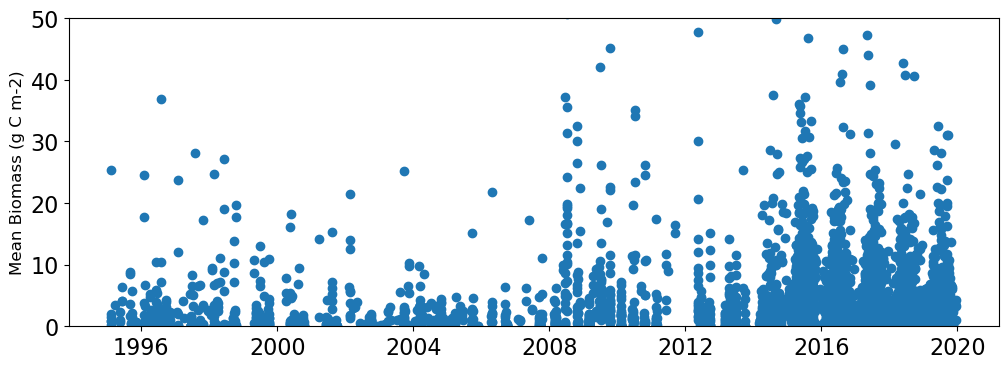

In [39]:
fig,ax=plt.subplots(1,1,figsize=(12,4))
ax.scatter(SalishSeadf['dtUTC'],SalishSeadf['Total mg m2']/1000)
ax.set_ylim(0,50)
ax.set_ylabel('Mean Biomass (g C m-2)',fontsize=12)


## Depth-Averaged Seasonal Cycles

Text(0.5, 0, 'Month')

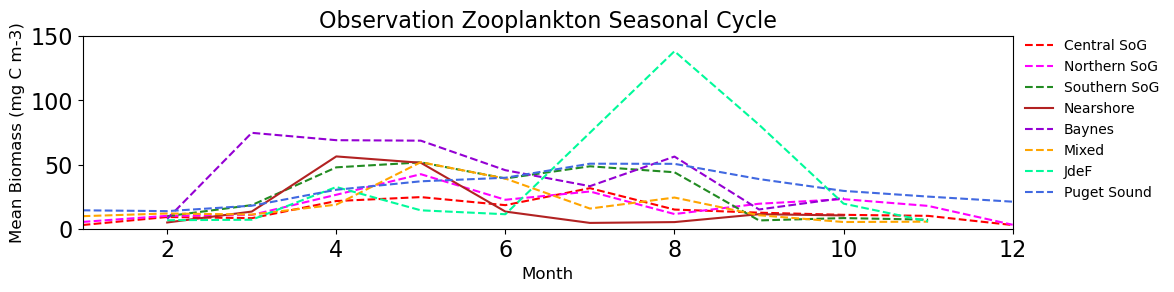

In [40]:
fig,ax=plt.subplots(1,1,figsize=(12,2.5))
ax.plot(logt_inv(monthlymeanCentralSoG['L10Total']),'--',color='red',label='Central SoG')
ax.plot(logt_inv(monthlymeanNorthernSoG['L10Total']),'--',color='fuchsia',label='Northern SoG')
ax.plot(logt_inv(monthlymeanSouthernSoG['L10Total']),'--',color='forestgreen',label='Southern SoG')
ax.plot(logt_inv(monthlymeanNearshoreNE['L10Total']),'-',color='firebrick',label='Nearshore')
ax.plot(logt_inv(monthlymeanBaynes['L10Total']),'--',color='darkviolet',label='Baynes')
ax.plot(logt_inv(monthlymeanMixed['L10Total']),'--',color='orange',label='Mixed')
ax.plot(logt_inv(monthlymeanJdF['L10Total']),'--',color='mediumspringgreen',label='JdeF')
ax.plot(logt_inv(monthlymeanPuget['L10Total']),'--',color='royalblue',label='Puget Sound')
#ax.plot(logt_inv(monthlymean['L10Total']),'-',color='k',linewidth=2,label='All')

ax.set_ylim(0,150)
ax.set_xlim(1,12)
ax.set_title('Observation Zooplankton Seasonal Cycle')
ax.set_ylabel('Mean Biomass (mg C m-3)',fontsize=12)
ax.legend(fontsize=10,frameon=False,bbox_to_anchor=(1., 1.05))
ax.set_xlabel('Month',fontsize=12)

Text(0.5, 0, 'Month')

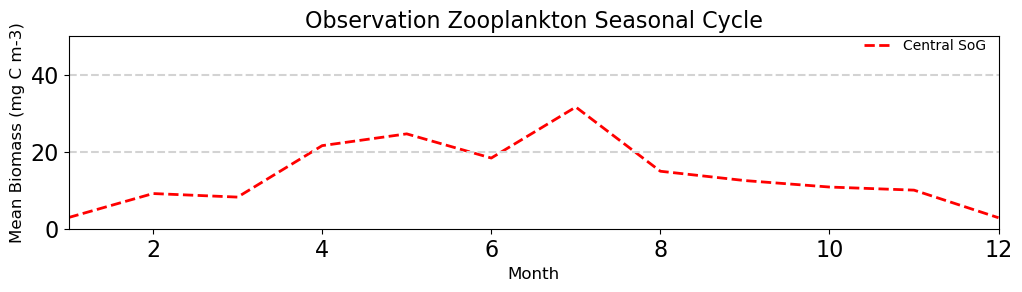

In [41]:
fig,ax=plt.subplots(1,1,figsize=(12,2.5))
ax.plot(logt_inv(monthlymeanCentralSoG['L10Total']),'--',color='red',linewidth=2,label='Central SoG')

ax.set_ylim(0,50)
ax.set_xlim(1,12)
ax.set_title('Observation Zooplankton Seasonal Cycle')
ax.set_ylabel('Mean Biomass (mg C m-3)',fontsize=12)
ax.legend(fontsize=10,frameon=False,bbox_to_anchor=(1., 1.05))
ax.axhline(y=20,linestyle='--',color='lightgrey')
#ax.axhline(y=30,linestyle='--')
ax.axhline(y=40,linestyle='--',color='lightgrey')
ax.set_xlabel('Month',fontsize=12)

Text(0.5, 0, 'Month')

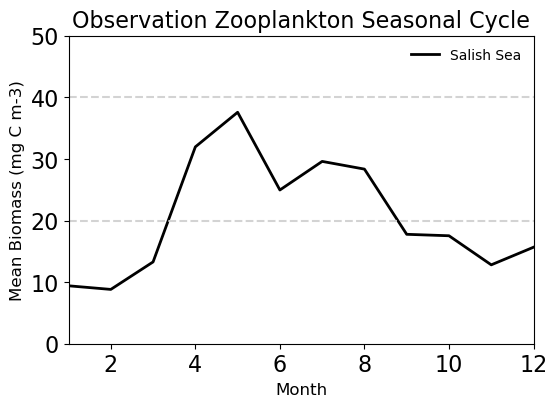

In [42]:
fig,ax=plt.subplots(1,1,figsize=(6,4))
ax.plot(logt_inv(monthlymean['L10Total']),'-',color='k',linewidth=2,label='Salish Sea')

ax.set_ylim(0,50)
ax.set_xlim(1,12)
ax.set_title('Observation Zooplankton Seasonal Cycle')
ax.set_ylabel('Mean Biomass (mg C m-3)',fontsize=12)
ax.legend(fontsize=10,frameon=False)
ax.axhline(y=20,linestyle='--',color='lightgrey')
#ax.axhline(y=30,linestyle='--')
ax.axhline(y=40,linestyle='--',color='lightgrey')
ax.set_xlabel('Month',fontsize=12)

In [43]:
logt_inv(monthlymean['L10Total'])

Month
1      9.404257
2      8.816309
3     13.278449
4     31.955153
5     37.571623
6     24.956751
7     29.597052
8     28.346346
9     17.761778
10    17.526622
11    12.805784
12    15.665653
Name: L10Total, dtype: float64

## Depth-Integrated Seasonal Cycles

Text(0.5, 0, 'Month')

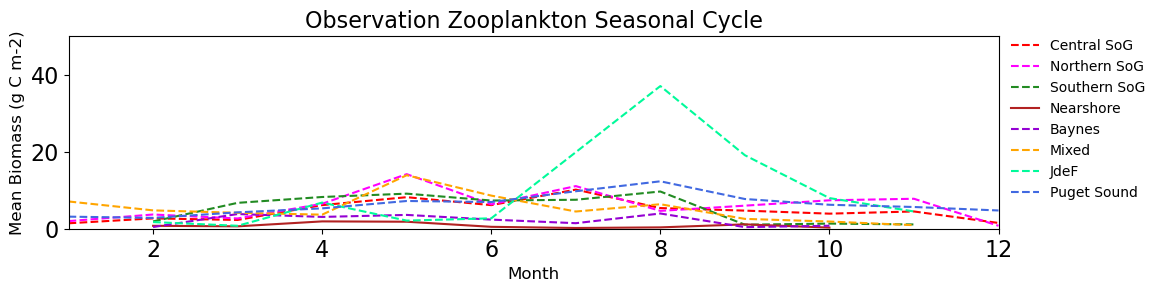

In [44]:
fig,ax=plt.subplots(1,1,figsize=(12,2.5))
ax.plot((monthlymeanCentralSoG['Total mg m2']/1000),'--',color='red',label='Central SoG')
ax.plot((monthlymeanNorthernSoG['Total mg m2']/1000),'--',color='fuchsia',label='Northern SoG')
ax.plot((monthlymeanSouthernSoG['Total mg m2']/1000),'--',color='forestgreen',label='Southern SoG')
ax.plot((monthlymeanNearshoreNE['Total mg m2']/1000),'-',color='firebrick',label='Nearshore')
ax.plot((monthlymeanBaynes['Total mg m2']/1000),'--',color='darkviolet',label='Baynes')
ax.plot((monthlymeanMixed['Total mg m2']/1000),'--',color='orange',label='Mixed')
ax.plot((monthlymeanJdF['Total mg m2']/1000),'--',color='mediumspringgreen',label='JdeF')
ax.plot((monthlymeanPuget['Total mg m2']/1000),'--',color='royalblue',label='Puget Sound')
#ax.plot(logt_inv(monthlymean['L10Total']),'-',color='k',linewidth=2,label='All')

ax.set_ylim(0,50)
ax.set_xlim(1,12)
ax.set_title('Observation Zooplankton Seasonal Cycle')
ax.set_ylabel('Mean Biomass (g C m-2)',fontsize=12)
ax.legend(fontsize=10,frameon=False,bbox_to_anchor=(1., 1.05))
ax.set_xlabel('Month',fontsize=12)

Text(0.5, 0, 'Month')

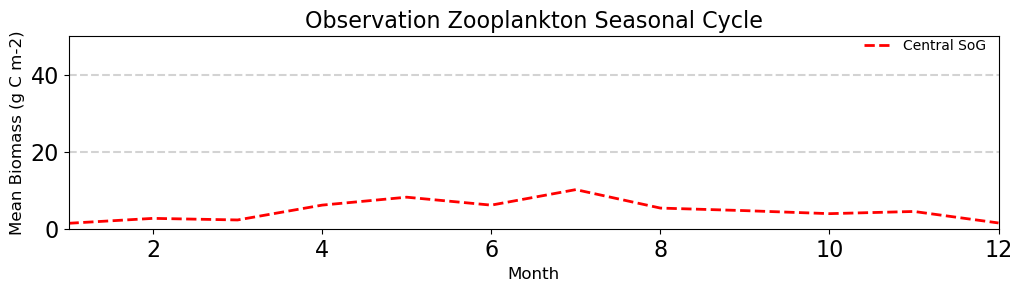

In [45]:
fig,ax=plt.subplots(1,1,figsize=(12,2.5))
ax.plot((monthlymeanCentralSoG['Total mg m2']/1000),'--',color='red',linewidth=2,label='Central SoG')

ax.set_ylim(0,50)
ax.set_xlim(1,12)
ax.set_title('Observation Zooplankton Seasonal Cycle')
ax.set_ylabel('Mean Biomass (g C m-2)',fontsize=12)
ax.legend(fontsize=10,frameon=False,bbox_to_anchor=(1., 1.05))
ax.axhline(y=20,linestyle='--',color='lightgrey')
#ax.axhline(y=30,linestyle='--')
ax.axhline(y=40,linestyle='--',color='lightgrey')
ax.set_xlabel('Month',fontsize=12)

Text(0.5, 0, 'Month')

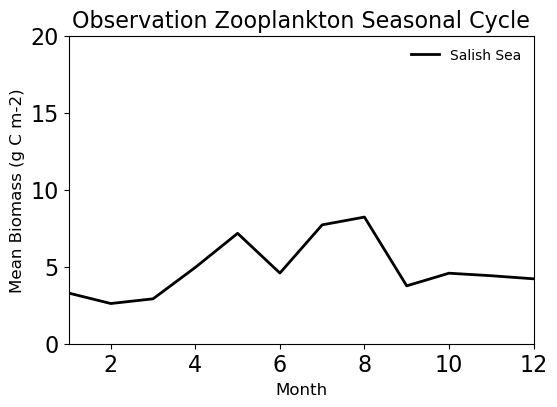

In [46]:
fig,ax=plt.subplots(1,1,figsize=(6,4))
ax.plot((monthlymean['Total mg m2']/1000),'-',color='k',linewidth=2,label='Salish Sea')

ax.set_ylim(0,20)
ax.set_xlim(1,12)
ax.set_title('Observation Zooplankton Seasonal Cycle')
ax.set_ylabel('Mean Biomass (g C m-2)',fontsize=12)
ax.legend(fontsize=10,frameon=False)
ax.axhline(y=20,linestyle='--',color='lightgrey')
#ax.axhline(y=30,linestyle='--')
ax.axhline(y=40,linestyle='--',color='lightgrey')
ax.set_xlabel('Month',fontsize=12)

In [47]:
(monthlymean['Total mg m2'])/1000

Month
1     3.291530
2     2.610311
3     2.915943
4     4.956731
5     7.167638
6     4.588396
7     7.718267
8     8.223986
9     3.757730
10    4.579136
11    4.414857
12    4.214952
Name: Total mg m2, dtype: float64